# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:red">  Numerical exercises 8: Metropolis - Variational Monte Carlo</span>

The task of this exercise was to find the ground state of a 1D quantum particle in the potential:

$$V(x) = x^4 -\frac{5}{2}\,x^2$$

This problem is not analitically solvable, so we will aproach it with a variational method, searching a wave function which minimizes the energy functional:

$$E[\Psi] = \frac{\langle \Psi \vert \hat H \vert \Psi \rangle}{\langle \Psi \vert \Psi \rangle} = \frac{\int dx\, \Psi^*(x)\, \hat H \,\Psi(x)}{\int dx\, \vert \Psi(x) \vert ^2} = \int dx \frac{|\Psi(x)|^2}{\int dx\, |\Psi(x)|^2} \frac{{\hat H}\, \Psi(x)}{\Psi(x)}$$

We will solve this integral via Monte Carlo integration computing the average distribution of the term $\frac{{\hat H}\, \Psi(x)}{\Psi(x)}$ sampling points distributed as $\frac{|\Psi(x)|^2}{\int dx\, |\Psi(x)|^2}$.  
The trial wave function we will use has the form:

$$\Psi^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+e^{-\frac{(x+\mu)^2}{2\sigma^2}}$$

The Hamiltonian operator acts on the wave function like:

$$\hat H = -\frac{1}{2}\frac{\partial^2}{\partial x^2} + V(x)$$

where I've set $\hbar = 1\;$, $m = 1\;$ in the kinetic part. We need to calculate the second derivative of the trial wave function; we have:

$$\frac{\partial \Psi}{\partial x} = -\frac{2(x-\mu)}{2\sigma^2}e^{-\frac{(x-\mu)^2}{2\sigma^2}}-\frac{2(x+\mu)}{2\sigma^2}e^{-\frac{(x+\mu)^2}{2\sigma^2}} = -\frac{1}{\sigma^2}\bigg[(x-\mu)e^{-\frac{(x-\mu)^2}{2\sigma^2}}+(x+\mu)e^{-\frac{(x+\mu)^2}{2\sigma^2}}\bigg]$$

$$\frac{\partial^2 \Psi}{\partial x^2} = \frac{\partial}{\partial x} \frac{\partial \Psi}{\partial x} = -\frac{1}{\sigma^2}\bigg[(x-\mu)\frac{-2(x-\mu)}{2\sigma^2}e^{-\frac{(x-\mu)^2}{2\sigma^2}} + e^{-\frac{(x-\mu)^2}{2\sigma^2}} + (x+\mu)\frac{-2(x+\mu)}{2\sigma^2}e^{-\frac{(x+\mu)^2}{2\sigma^2}} + e^{-\frac{(x+\mu)^2}{2\sigma^2}}\bigg] = -\frac{1}{\sigma^2}\bigg[\bigg(1-\big(\frac{x-\mu}{\sigma}\big)^2\bigg)e^{-\frac{(x-\mu)^2}{2\sigma^2}}+\bigg(1-\big(\frac{x+\mu}{\sigma}\big)^2\bigg)e^{-\frac{(x+\mu)^2}{2\sigma^2}}\bigg]$$

Summing up, in the program I integrate via Monte Carlo the function:

$$\frac{\hat H\,\Psi(x)}{\Psi(x)} = \frac{-\frac{1}{2}\frac{\partial^2 \Psi}{\partial x^2} + V(x)\Psi(x)}{\Psi(x)}$$

obtaining, with data blocking method, average values (and statistical uncertainties) for energy of the state $\vert \Psi \rangle$ as a function of the number of blocks; the Monte Carlo integration samples points distributed as $\frac{|\Psi(x)|^2}{\int dx\, |\Psi(x)|^2}$ using Metropolis algorithm (note that we don't need to compute the explicit normalization of the wave function because it vanishes thanks to Metropolis).  
Before we can start the simulation, we need to equilibrate the $\delta$ of Metropolis poposed moves (the new position $x_{new}$ is proposed uniformly in $[x_{old}-\delta, x_{old} + \delta]$) in order to obtain $\sim$ 50% acceptance rate. This equilibration is realized with a *equilibration* variable in the input file which, if set to 1, forces the program to only equilibrate the value of $\delta$, printing it on a file called delta.dat (the number of steps in the equilibration phase has to be set in the *nblk* variable). We are then ready to start the real simulation setting *equilibration* = 0 (or any other value $\neq 1$) and the desired number of blocks, number of steps per block, parameters $\mu$, $\sigma$ and the starting point $x_0$ (I suggest $x_0 \sim \mu$). 

The following python script runs the code for *dim* values of $\mu$ and *dim* values of $\sigma$, which are stored in two vectors, so the program is run $dim^2$ times, storing all the values of energy obtained at the end of each simulation in an array (the equilibration phase is also already implemented before each simulation). At the and of the $dim^2$ runs, the script selects the minimum value of energy and its index in the array (say $i_{ene}$) and finds the corresponding values of $\mu$ and $\sigma$ by:

$$i_{\mu} = (int)\frac{i_{ene}}{dim}\;\; , \;\; i_{\sigma} = i_{ene} - i_{\mu}*dim$$

because the program is run fixing a value of $\mu$ and exploring all *dim* values of $\sigma$, then passing to the successive value of $\mu$ and exploring all *dim* values of $\sigma$ and so on.

The values explored for $\mu$ are selected between variables $\mu_{min}$, $\mu_{max}$ equally spaced by $(\mu_{max}-\mu_{min})/(dim-1)$ (and analogously for $\sigma$).

In [29]:
%%time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import subprocess

f = open("input.dat", "r+")
lines = f.readlines()
f.close()
dim=30
mu_min = 0.5
mu_max = 1.0
sigma_min = 0.4
sigma_max = 0.8
mu=np.zeros(dim)
sigma=np.zeros(dim)
energy=np.zeros(dim*dim)
for j in range (0,dim):
    mu[j] = mu_min + (j/(dim-1))*(mu_max-mu_min)
    sigma[j] = sigma_min + (j/(dim-1))*(sigma_max-sigma_min)

i=0
for k in range (0,dim):
    lines[1]=(str)(mu[k]) + "\n"
    lines[3]=(str)(mu[k]) + "\n"
    for j in range (0,dim):
        lines[0]=(str)(1) + "\n" #equilibration
        lines[2]=(str)(sigma[j]) + "\n"
        lines[7]=(str)(1000) + "\n" #nsteps for equilibration
        f = open("input.dat", "w+")
        for line in lines:
            f.write(line)
        f.close()
        cmd = "./Variational_MC.exe"
        returned_value = subprocess.call(cmd, shell=True)
        lines[0]=(str)(0) + "\n" #simulation
        lines[7]=(str)(100) + "\n" #nblocks
        f = open("input.dat", "w+")
        for line in lines:
            f.write(line)
        f.close()
        cmd = "./Variational_MC.exe"
        returned_value = subprocess.call(cmd, shell=True)
        energy[i]=np.loadtxt("energy.txt", skiprows=((int)(lines[7])-1), usecols=(1), unpack='true')
        i+=1
        
energy_best = min(energy)
iene=0
imu=0
isigma=0
for k in range (0,dim*dim):
    if (energy[k]==energy_best):
        iene=k
        
imu=(int)(iene/dim)
isigma=iene-imu*dim

mu_best=mu[imu]
sigma_best=sigma[isigma]

lines[0]=(str)(1) + "\n" #equilibration
lines[1]=(str)(mu_best) + "\n"
lines[2]=(str)(sigma_best) + "\n"
lines[3]=(str)(mu_best) + "\n"
lines[7]=(str)(1000) + "\n" #nsteps for equilibration
f = open("input.dat", "w+")
for line in lines:
    f.write(line)
f.close()
cmd = "./Variational_MC.exe"
returned_value = subprocess.call(cmd, shell=True)
lines[0]=(str)(0) + "\n" #simulation
lines[7]=(str)(100) + "\n" #nblocks
f = open("input.dat", "w+")
for line in lines:
    f.write(line)
f.close()
cmd = "./Variational_MC.exe"
returned_value = subprocess.call(cmd, shell=True)

print("mu best = ", mu_best)
print("sigma best = ", sigma_best)
print("energy best = ", energy_best)

mu best =  0.7931034482758621
sigma best =  0.6206896551724138
energy best =  -0.444863
CPU times: user 1.11 s, sys: 3.28 s, total: 4.4 s
Wall time: 5min 29s


The graphs below represent the ground state energy trend as a function of the number of blocks, and the square modulus of the corresponding wave function, compared to the values obtained via the discretization of the Schrödinger equation.

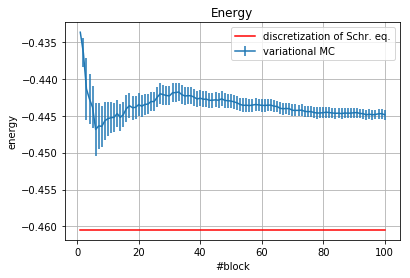

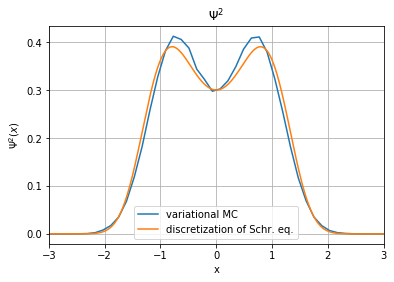

In [30]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def Vpot(y):
    return (y**2 - 2.5)*y**2
    #return 0.5*y**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x_discr = np.linspace(-a/2, a/2, N)
dx = x_discr[1] - x_discr[0] # the step size
V = Vpot(x_discr)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi_discr = np.linalg.eigh(H)

# Take the transpose & normalize
psi_discr = np.transpose(psi_discr)
psi_discr = psi_discr/np.sqrt(dx)


n, ene, ene_error = np.loadtxt("energy.txt", usecols=(0,1,2), unpack = 'true')
discr_ene=np.full(100, E[0])
plt.errorbar(n, ene, yerr=ene_error, label='variational MC')
plt.plot(n, discr_ene, color='r', label = 'discretization of Schr. eq.')
plt.xlabel("#block")
plt.ylabel("energy")
plt.title("Energy")
plt.grid()
plt.legend()
plt.show()

x, psi = np.loadtxt("psi_squared.txt", usecols=(0,1), unpack='true')
plt.plot(x,psi,label='variational MC')
plt.plot(x_discr, psi_discr[0]**2, label='discretization of Schr. eq.')
plt.xlabel("x")
plt.ylabel("$\Psi^2(x)$")
plt.xlim((-3,3))
plt.title("$\Psi^2$")
plt.grid()
plt.legend()

plt.show()

The results of variational MC are not in agreement with those obtained discretizing Schrödinger equation; this probably occurs because the trial wave function we have used is not the best wave function to describe a particle in the prescribed potential. I suppose that using a wave function which is the square root of the one we have used one can obtained a more precise result, because in this case we will have that the square modulus of the wave function (i.e. the probability distribution for the positions of the particle in the potential) is the sum of two gaussians, which I expect to describe well a particle in the given potential.